# Phase 3: Model Training & Evaluation - v2 (Overfitting Reduction)

## Objective
Address overfitting issues from v1 by testing multiple regularization strategies.

## Changes from v1:
1. **Strategy A**: No SMOTE + Balanced Class Weights Only
2. **Strategy B**: Minimal SMOTE (1:1000 ratio) + Moderate Regularization
3. **Strategy C**: Very Conservative SMOTE (1:500) + Maximum Regularization

## Target Metrics:
- **OOB Score**: 0.85-0.95 (not 0.99+)
- **Test AUC-ROC**: 0.90-0.97 (not 0.999+)
- **Recall**: 80-95% (acceptable tradeoff)
- **Precision**: 50-75% (improved from 46%)

## Input
- **Engineered Dataset:** `data/processed/Phase 2 - Feature Engineering/features_engineered.csv`
- **Records:** 778,692 events
- **Features:** 87 columns (75 after exclusions)
- **Labels:** 247 timestomped events (1:3,151 imbalance)

---
## 1. Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import joblib
from datetime import datetime

# Machine Learning
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    roc_curve,
    precision_recall_curve, 
    average_precision_score,
    f1_score,
    precision_score,
    recall_score
)
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 8)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [2]:
# Define paths
notebook_dir = Path.cwd()
print(f"Current working directory: {notebook_dir}")

# Navigate to project root
if 'notebooks' in str(notebook_dir):
    BASE_DIR = notebook_dir.parent.parent / 'data'
else:
    BASE_DIR = Path('data')

INPUT_FILE = BASE_DIR / 'processed' / 'Phase 2 - Feature Engineering' / 'features_engineered.csv'
OUTPUT_DIR = BASE_DIR / 'processed' / 'Phase 3 - Model Training' / 'v2_experiments'

# Ensure output directory exists
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n📂 Directory Configuration:")
print(f"  Input:  {INPUT_FILE} {'✓' if INPUT_FILE.exists() else '✗ NOT FOUND'}")
print(f"  Output: {OUTPUT_DIR} ✓")

Current working directory: /Users/soni/Github/Digital-Detectives_Thesis

📂 Directory Configuration:
  Input:  data/processed/Phase 2 - Feature Engineering/features_engineered.csv ✓
  Output: data/processed/Phase 3 - Model Training/v2_experiments ✓


---
## 2. Load Data & Preparation (Same as v1)

In [3]:
print("\n" + "=" * 80)
print("LOADING ENGINEERED FEATURES")
print("=" * 80)

# Load dataset
df = pd.read_csv(INPUT_FILE, encoding='utf-8-sig')

print(f"\n📊 Dataset Loaded:")
print(f"   Records: {len(df):,}")
print(f"   Features: {len(df.columns)}")
print(f"   Timestomped events: {df['is_timestomped'].sum()}")

# Class distribution
print(f"\n📈 Class Distribution:")
class_counts = df['is_timestomped'].value_counts().sort_index()
for label, count in class_counts.items():
    pct = count / len(df) * 100
    print(f"   Class {int(label)}: {count:,} ({pct:.3f}%)")

imbalance_ratio = class_counts[0] / class_counts[1]
print(f"\n   ⚠️  Imbalance Ratio: 1:{int(imbalance_ratio)}")


LOADING ENGINEERED FEATURES

📊 Dataset Loaded:
   Records: 778,692
   Features: 87
   Timestomped events: 247.0

📈 Class Distribution:
   Class 0: 778,445 (99.968%)
   Class 1: 247 (0.032%)

   ⚠️  Imbalance Ratio: 1:3151


In [4]:
print("\n" + "=" * 80)
print("DATA PREPARATION")
print("=" * 80)

# Columns to exclude from features (prevent data leakage)
cols_to_exclude = [
    'is_timestomped',           # Target variable
    'is_timestomped_lf',        # Artifact-level labels
    'is_timestomped_usn',
    'timestomp_tool_executed',  # Highly correlated with target
    'timestomp_tool_executed_lf',
    'timestomp_tool_executed_usn',
    'case_id',                  # Use for stratified split, not as feature
    'eventtime_dt',             # Already extracted features
    'label_source_both',        # Label metadata (LEAKAGE)
    'label_source_logfile',
    'label_source_usnjrnl',
    'label_source_nan',
]

# Get feature columns
feature_cols = [col for col in df.columns if col not in cols_to_exclude]

print(f"\n✓ Feature columns: {len(feature_cols)}")

# Convert bool to int
bool_cols = df[feature_cols].select_dtypes(include='bool').columns.tolist()
if bool_cols:
    for col in bool_cols:
        df[col] = df[col].astype(int)

# Create X and y
X = df[feature_cols].copy()
y = df['is_timestomped'].copy()
case_ids = df['case_id'].copy()

# Fill missing values
X = X.fillna(0)

print(f"\n✅ Data preparation complete!")
print(f"   Final X shape: {X.shape}")
print(f"   Features: {X.shape[1]}")
print(f"   Samples: {X.shape[0]:,}")


DATA PREPARATION

✓ Feature columns: 75

✅ Data preparation complete!
   Final X shape: (778692, 75)
   Features: 75
   Samples: 778,692


---
## 3. Train/Test Split (Same as v1)

In [5]:
print("\n" + "=" * 80)
print("TRAIN/TEST SPLIT: CASE-BASED STRATIFICATION")
print("=" * 80)

# Analyze case distribution
case_stats = df.groupby('case_id').agg({
    'is_timestomped': ['sum', 'count']
}).reset_index()
case_stats.columns = ['case_id', 'timestomped_count', 'total_events']

# Categorize cases
high_timestomp_cases = case_stats[case_stats['timestomped_count'] >= 30]['case_id'].tolist()
med_timestomp_cases = case_stats[(case_stats['timestomped_count'] >= 2) & (case_stats['timestomped_count'] < 30)]['case_id'].tolist()
low_timestomp_cases = case_stats[(case_stats['timestomped_count'] > 0) & (case_stats['timestomped_count'] < 2)]['case_id'].tolist()

print(f"\n   High timestomp cases (>= 30): {high_timestomp_cases}")
print(f"   Med timestomp cases (2-29):   {med_timestomp_cases}")
print(f"   Low timestomp cases (1):      {low_timestomp_cases}")

# Manual stratified split
from sklearn.model_selection import train_test_split as split_list

train_cases = []
test_cases = []

if len(high_timestomp_cases) >= 2:
    train_high, test_high = split_list(high_timestomp_cases, test_size=0.25, random_state=42)
    train_cases.extend(train_high)
    test_cases.extend(test_high)
else:
    train_cases.extend(high_timestomp_cases)

if len(med_timestomp_cases) >= 2:
    train_med, test_med = split_list(med_timestomp_cases, test_size=0.25, random_state=42)
    train_cases.extend(train_med)
    test_cases.extend(test_med)
else:
    train_cases.extend(med_timestomp_cases)

if len(low_timestomp_cases) >= 2:
    train_low, test_low = split_list(low_timestomp_cases, test_size=0.25, random_state=42)
    train_cases.extend(train_low)
    test_cases.extend(test_low)
else:
    train_cases.extend(low_timestomp_cases)

print(f"\n   Train cases ({len(train_cases)}): {sorted(train_cases)}")
print(f"   Test cases ({len(test_cases)}): {sorted(test_cases)}")

# Create train/test masks
train_mask = case_ids.isin(train_cases)
test_mask = case_ids.isin(test_cases)

# Split data
X_train = X[train_mask].copy()
X_test = X[test_mask].copy()
y_train = y[train_mask].copy()
y_test = y[test_mask].copy()

print(f"\n✅ Split complete!")
print(f"   Train: {len(X_train):,} samples, {int(y_train.sum())} timestomped")
print(f"   Test:  {len(X_test):,} samples, {int(y_test.sum())} timestomped")


TRAIN/TEST SPLIT: CASE-BASED STRATIFICATION

   High timestomp cases (>= 30): [6, 8, 9, 10, 12]
   Med timestomp cases (2-29):   [1, 3, 4]
   Low timestomp cases (1):      [2, 5, 7, 11]

   Train cases (8): [2, 3, 4, 6, 7, 9, 10, 11]
   Test cases (4): [1, 5, 8, 12]

✅ Split complete!
   Train: 483,153 samples, 145 timestomped
   Test:  295,539 samples, 102 timestomped


---
## 4. Strategy A: No SMOTE + Balanced Class Weights Only

**Rationale**: SMOTE creates synthetic data which may cause overfitting. Let's try relying solely on class weights.

**Expected Impact**:
- OOB Score: 0.85-0.92 (lower than 0.999)
- Recall: May drop to 75-85%
- Precision: Should improve to 55-70%

In [6]:
print("\n" + "=" * 80)
print("STRATEGY A: NO SMOTE + BALANCED CLASS WEIGHTS")
print("=" * 80)

# No SMOTE - use original training data
X_train_A = X_train.copy()
y_train_A = y_train.copy()

print(f"\n1️⃣ Training data (NO SMOTE):")
print(f"   Train samples: {len(X_train_A):,}")
print(f"   Timestomped: {int(y_train_A.sum())}")
print(f"   Imbalance: 1:{int((y_train_A == 0).sum() / y_train_A.sum())}")

# Calculate balanced class weights
minority_count = y_train_A.sum()
majority_count = (y_train_A == 0).sum()
weight_ratio = majority_count / minority_count

# Use moderate weight (not full ratio to avoid overfitting)
minority_weight = weight_ratio * 0.3  # 30% of full weight
majority_weight = 1.0

print(f"\n2️⃣ Class weights:")
print(f"   Class 0 (Benign): {majority_weight:.1f}")
print(f"   Class 1 (Timestomped): {minority_weight:.1f}")
print(f"   (Using 30% of full weight ratio {weight_ratio:.1f})")

# Initialize Random Forest with STRONG regularization
rf_model_A = RandomForestClassifier(
    n_estimators=50,             # REDUCED trees
    max_depth=3,                 # VERY shallow
    min_samples_split=500,       # HIGH split requirement
    min_samples_leaf=250,        # HIGH leaf requirement
    max_leaf_nodes=15,           # VERY FEW leaves
    max_features='sqrt',
    class_weight={0: majority_weight, 1: minority_weight},
    random_state=42,
    n_jobs=-1,
    bootstrap=True,
    oob_score=True
)

print(f"\n3️⃣ Model configuration:")
print(f"   Trees: {rf_model_A.n_estimators}")
print(f"   Max Depth: {rf_model_A.max_depth}")
print(f"   Min Samples Split: {rf_model_A.min_samples_split}")
print(f"   Min Samples Leaf: {rf_model_A.min_samples_leaf}")
print(f"   Max Leaf Nodes: {rf_model_A.max_leaf_nodes}")

# Train model
print(f"\n4️⃣ Training model...")
rf_model_A.fit(X_train_A, y_train_A)

# Training performance
y_train_pred_A = rf_model_A.predict(X_train_A)
train_precision_A = precision_score(y_train_A, y_train_pred_A)
train_recall_A = recall_score(y_train_A, y_train_pred_A)

print(f"\n5️⃣ Training Performance:")
print(f"   Precision: {train_precision_A:.3f}")
print(f"   Recall: {train_recall_A:.3f}")
print(f"   OOB Score: {rf_model_A.oob_score_:.3f}")

if rf_model_A.oob_score_ > 0.98:
    print(f"   ⚠️  OOB still too high - still overfitting")
elif rf_model_A.oob_score_ < 0.80:
    print(f"   ⚠️  OOB too low - underfitting")
else:
    print(f"   ✓ OOB in target range (0.80-0.98)")

# Test set evaluation
print(f"\n6️⃣ Test Set Performance:")
y_test_pred_A = rf_model_A.predict(X_test)
y_test_pred_proba_A = rf_model_A.predict_proba(X_test)[:, 1]

test_precision_A = precision_score(y_test, y_test_pred_A, zero_division=0)
test_recall_A = recall_score(y_test, y_test_pred_A, zero_division=0)
test_f1_A = f1_score(y_test, y_test_pred_A, zero_division=0)
auc_roc_A = roc_auc_score(y_test, y_test_pred_proba_A) if y_test.sum() > 0 else 0
auc_pr_A = average_precision_score(y_test, y_test_pred_proba_A) if y_test.sum() > 0 else 0

print(f"   Precision: {test_precision_A:.3f}")
print(f"   Recall:    {test_recall_A:.3f}")
print(f"   F1-Score:  {test_f1_A:.3f}")
print(f"   AUC-ROC:   {auc_roc_A:.3f}")
print(f"   AUC-PR:    {auc_pr_A:.3f}")

cm_A = confusion_matrix(y_test, y_test_pred_A)
tn_A, fp_A, fn_A, tp_A = cm_A.ravel()

print(f"\n   Confusion Matrix:")
print(f"   TP: {tp_A}, FP: {fp_A}, TN: {tn_A}, FN: {fn_A}")

print(f"\n✅ Strategy A Complete!")


STRATEGY A: NO SMOTE + BALANCED CLASS WEIGHTS

1️⃣ Training data (NO SMOTE):
   Train samples: 483,153
   Timestomped: 145
   Imbalance: 1:3331

2️⃣ Class weights:
   Class 0 (Benign): 1.0
   Class 1 (Timestomped): 999.3
   (Using 30% of full weight ratio 3331.1)

3️⃣ Model configuration:
   Trees: 50
   Max Depth: 3
   Min Samples Split: 500
   Min Samples Leaf: 250
   Max Leaf Nodes: 15

4️⃣ Training model...

5️⃣ Training Performance:
   Precision: 0.128
   Recall: 0.945
   OOB Score: 0.998
   ⚠️  OOB still too high - still overfitting

6️⃣ Test Set Performance:
   Precision: 0.114
   Recall:    0.971
   F1-Score:  0.204
   AUC-ROC:   0.999
   AUC-PR:    0.363

   Confusion Matrix:
   TP: 99, FP: 769, TN: 294668, FN: 3

✅ Strategy A Complete!


---
## 5. Strategy B: Minimal SMOTE (1:1000) + Moderate Regularization

**Rationale**: Use very conservative SMOTE to slightly help the model, but keep regularization strong.

**Expected Impact**:
- OOB Score: 0.88-0.94
- Recall: 80-90%
- Precision: 50-65%

In [7]:
print("\n" + "=" * 80)
print("STRATEGY B: MINIMAL SMOTE (1:1000) + MODERATE REGULARIZATION")
print("=" * 80)

# Apply very conservative SMOTE
minority_count = y_train.sum()
majority_count = (y_train == 0).sum()
target_minority_count = int(majority_count / 1000)  # 1:1000 ratio

print(f"\n1️⃣ Applying minimal SMOTE:")
print(f"   Current minority: {minority_count}")
print(f"   Target minority: {target_minority_count}")
print(f"   Will create: {target_minority_count - minority_count} synthetic samples")
print(f"   Target ratio: 1:1000 (very conservative)")

smote_B = SMOTE(
    sampling_strategy=target_minority_count / majority_count,
    random_state=42,
    k_neighbors=3  # Fewer neighbors = less aggressive
)

X_train_B, y_train_B = smote_B.fit_resample(X_train, y_train)

print(f"\n2️⃣ After SMOTE:")
print(f"   Train samples: {len(X_train_B):,}")
print(f"   Timestomped: {int(y_train_B.sum())}")
print(f"   Imbalance: 1:{int((y_train_B == 0).sum() / y_train_B.sum())}")

# Moderate class weights
minority_weight_B = 5.0
majority_weight_B = 1.0

print(f"\n3️⃣ Class weights:")
print(f"   Class 0: {majority_weight_B}")
print(f"   Class 1: {minority_weight_B}")

# Initialize Random Forest with MODERATE regularization
rf_model_B = RandomForestClassifier(
    n_estimators=50,
    max_depth=4,                 # Slightly deeper than Strategy A
    min_samples_split=300,
    min_samples_leaf=150,
    max_leaf_nodes=25,
    max_features='sqrt',
    class_weight={0: majority_weight_B, 1: minority_weight_B},
    random_state=42,
    n_jobs=-1,
    bootstrap=True,
    oob_score=True
)

print(f"\n4️⃣ Model configuration:")
print(f"   Trees: {rf_model_B.n_estimators}")
print(f"   Max Depth: {rf_model_B.max_depth}")
print(f"   Min Samples Split: {rf_model_B.min_samples_split}")
print(f"   Min Samples Leaf: {rf_model_B.min_samples_leaf}")

# Train model
print(f"\n5️⃣ Training model...")
rf_model_B.fit(X_train_B, y_train_B)

# Training performance
y_train_pred_B = rf_model_B.predict(X_train_B)
train_precision_B = precision_score(y_train_B, y_train_pred_B)
train_recall_B = recall_score(y_train_B, y_train_pred_B)

print(f"\n6️⃣ Training Performance:")
print(f"   Precision: {train_precision_B:.3f}")
print(f"   Recall: {train_recall_B:.3f}")
print(f"   OOB Score: {rf_model_B.oob_score_:.3f}")

if rf_model_B.oob_score_ > 0.98:
    print(f"   ⚠️  OOB still too high - still overfitting")
elif rf_model_B.oob_score_ < 0.80:
    print(f"   ⚠️  OOB too low - underfitting")
else:
    print(f"   ✓ OOB in target range (0.80-0.98)")

# Test set evaluation
print(f"\n7️⃣ Test Set Performance:")
y_test_pred_B = rf_model_B.predict(X_test)
y_test_pred_proba_B = rf_model_B.predict_proba(X_test)[:, 1]

test_precision_B = precision_score(y_test, y_test_pred_B, zero_division=0)
test_recall_B = recall_score(y_test, y_test_pred_B, zero_division=0)
test_f1_B = f1_score(y_test, y_test_pred_B, zero_division=0)
auc_roc_B = roc_auc_score(y_test, y_test_pred_proba_B) if y_test.sum() > 0 else 0
auc_pr_B = average_precision_score(y_test, y_test_pred_proba_B) if y_test.sum() > 0 else 0

print(f"   Precision: {test_precision_B:.3f}")
print(f"   Recall:    {test_recall_B:.3f}")
print(f"   F1-Score:  {test_f1_B:.3f}")
print(f"   AUC-ROC:   {auc_roc_B:.3f}")
print(f"   AUC-PR:    {auc_pr_B:.3f}")

cm_B = confusion_matrix(y_test, y_test_pred_B)
tn_B, fp_B, fn_B, tp_B = cm_B.ravel()

print(f"\n   Confusion Matrix:")
print(f"   TP: {tp_B}, FP: {fp_B}, TN: {tn_B}, FN: {fn_B}")

print(f"\n✅ Strategy B Complete!")


STRATEGY B: MINIMAL SMOTE (1:1000) + MODERATE REGULARIZATION

1️⃣ Applying minimal SMOTE:
   Current minority: 145.0
   Target minority: 483
   Will create: 338.0 synthetic samples
   Target ratio: 1:1000 (very conservative)

2️⃣ After SMOTE:
   Train samples: 483,490
   Timestomped: 482
   Imbalance: 1:1002

3️⃣ Class weights:
   Class 0: 1.0
   Class 1: 5.0

4️⃣ Model configuration:
   Trees: 50
   Max Depth: 4
   Min Samples Split: 300
   Min Samples Leaf: 150

5️⃣ Training model...

6️⃣ Training Performance:
   Precision: 0.655
   Recall: 0.873
   OOB Score: 0.999
   ⚠️  OOB still too high - still overfitting

7️⃣ Test Set Performance:
   Precision: 0.427
   Recall:    0.657
   F1-Score:  0.517
   AUC-ROC:   0.999
   AUC-PR:    0.348

   Confusion Matrix:
   TP: 67, FP: 90, TN: 295347, FN: 35

✅ Strategy B Complete!


---
## 6. Strategy C: Very Conservative SMOTE (1:500) + Maximum Regularization

**Rationale**: Slightly more SMOTE than B, but with maximum regularization constraints.

**Expected Impact**:
- OOB Score: 0.90-0.96
- Recall: 85-92%
- Precision: 48-60%

In [8]:
print("\n" + "=" * 80)
print("STRATEGY C: CONSERVATIVE SMOTE (1:500) + MAXIMUM REGULARIZATION")
print("=" * 80)

# Apply conservative SMOTE
target_minority_count = int(majority_count / 500)  # 1:500 ratio

print(f"\n1️⃣ Applying conservative SMOTE:")
print(f"   Current minority: {minority_count}")
print(f"   Target minority: {target_minority_count}")
print(f"   Will create: {target_minority_count - minority_count} synthetic samples")
print(f"   Target ratio: 1:500")

smote_C = SMOTE(
    sampling_strategy=target_minority_count / majority_count,
    random_state=42,
    k_neighbors=3
)

X_train_C, y_train_C = smote_C.fit_resample(X_train, y_train)

print(f"\n2️⃣ After SMOTE:")
print(f"   Train samples: {len(X_train_C):,}")
print(f"   Timestomped: {int(y_train_C.sum())}")
print(f"   Imbalance: 1:{int((y_train_C == 0).sum() / y_train_C.sum())}")

# Lower class weights (since we have more synthetic data)
minority_weight_C = 3.0
majority_weight_C = 1.0

print(f"\n3️⃣ Class weights:")
print(f"   Class 0: {majority_weight_C}")
print(f"   Class 1: {minority_weight_C}")

# Initialize Random Forest with MAXIMUM regularization
rf_model_C = RandomForestClassifier(
    n_estimators=40,             # Even fewer trees
    max_depth=3,                 # Very shallow
    min_samples_split=400,
    min_samples_leaf=200,
    max_leaf_nodes=20,
    max_features='sqrt',
    class_weight={0: majority_weight_C, 1: minority_weight_C},
    random_state=42,
    n_jobs=-1,
    bootstrap=True,
    oob_score=True
)

print(f"\n4️⃣ Model configuration:")
print(f"   Trees: {rf_model_C.n_estimators}")
print(f"   Max Depth: {rf_model_C.max_depth}")
print(f"   Min Samples Split: {rf_model_C.min_samples_split}")
print(f"   Min Samples Leaf: {rf_model_C.min_samples_leaf}")

# Train model
print(f"\n5️⃣ Training model...")
rf_model_C.fit(X_train_C, y_train_C)

# Training performance
y_train_pred_C = rf_model_C.predict(X_train_C)
train_precision_C = precision_score(y_train_C, y_train_pred_C)
train_recall_C = recall_score(y_train_C, y_train_pred_C)

print(f"\n6️⃣ Training Performance:")
print(f"   Precision: {train_precision_C:.3f}")
print(f"   Recall: {train_recall_C:.3f}")
print(f"   OOB Score: {rf_model_C.oob_score_:.3f}")

if rf_model_C.oob_score_ > 0.98:
    print(f"   ⚠️  OOB still too high - still overfitting")
elif rf_model_C.oob_score_ < 0.80:
    print(f"   ⚠️  OOB too low - underfitting")
else:
    print(f"   ✓ OOB in target range (0.80-0.98)")

# Test set evaluation
print(f"\n7️⃣ Test Set Performance:")
y_test_pred_C = rf_model_C.predict(X_test)
y_test_pred_proba_C = rf_model_C.predict_proba(X_test)[:, 1]

test_precision_C = precision_score(y_test, y_test_pred_C, zero_division=0)
test_recall_C = recall_score(y_test, y_test_pred_C, zero_division=0)
test_f1_C = f1_score(y_test, y_test_pred_C, zero_division=0)
auc_roc_C = roc_auc_score(y_test, y_test_pred_proba_C) if y_test.sum() > 0 else 0
auc_pr_C = average_precision_score(y_test, y_test_pred_proba_C) if y_test.sum() > 0 else 0

print(f"   Precision: {test_precision_C:.3f}")
print(f"   Recall:    {test_recall_C:.3f}")
print(f"   F1-Score:  {test_f1_C:.3f}")
print(f"   AUC-ROC:   {auc_roc_C:.3f}")
print(f"   AUC-PR:    {auc_pr_C:.3f}")

cm_C = confusion_matrix(y_test, y_test_pred_C)
tn_C, fp_C, fn_C, tp_C = cm_C.ravel()

print(f"\n   Confusion Matrix:")
print(f"   TP: {tp_C}, FP: {fp_C}, TN: {tn_C}, FN: {fn_C}")

print(f"\n✅ Strategy C Complete!")


STRATEGY C: CONSERVATIVE SMOTE (1:500) + MAXIMUM REGULARIZATION

1️⃣ Applying conservative SMOTE:
   Current minority: 145.0
   Target minority: 966
   Will create: 821.0 synthetic samples
   Target ratio: 1:500

2️⃣ After SMOTE:
   Train samples: 483,973
   Timestomped: 965
   Imbalance: 1:500

3️⃣ Class weights:
   Class 0: 1.0
   Class 1: 3.0

4️⃣ Model configuration:
   Trees: 40
   Max Depth: 3
   Min Samples Split: 400
   Min Samples Leaf: 200

5️⃣ Training model...

6️⃣ Training Performance:
   Precision: 0.744
   Recall: 0.482
   OOB Score: 0.999
   ⚠️  OOB still too high - still overfitting

7️⃣ Test Set Performance:
   Precision: 0.429
   Recall:    0.647
   F1-Score:  0.516
   AUC-ROC:   0.999
   AUC-PR:    0.347

   Confusion Matrix:
   TP: 66, FP: 88, TN: 295349, FN: 36

✅ Strategy C Complete!


---
## 7. Comparison of All Strategies

In [9]:
print("\n" + "=" * 80)
print("STRATEGY COMPARISON")
print("=" * 80)

# Create comparison dataframe
comparison = pd.DataFrame([
    {
        'Strategy': 'A: No SMOTE',
        'SMOTE_Ratio': 'None',
        'Train_Samples': len(X_train_A),
        'OOB_Score': rf_model_A.oob_score_,
        'Test_Precision': test_precision_A,
        'Test_Recall': test_recall_A,
        'Test_F1': test_f1_A,
        'AUC_ROC': auc_roc_A,
        'AUC_PR': auc_pr_A,
        'TP': tp_A,
        'FP': fp_A,
        'FN': fn_A
    },
    {
        'Strategy': 'B: Minimal SMOTE (1:1000)',
        'SMOTE_Ratio': '1:1000',
        'Train_Samples': len(X_train_B),
        'OOB_Score': rf_model_B.oob_score_,
        'Test_Precision': test_precision_B,
        'Test_Recall': test_recall_B,
        'Test_F1': test_f1_B,
        'AUC_ROC': auc_roc_B,
        'AUC_PR': auc_pr_B,
        'TP': tp_B,
        'FP': fp_B,
        'FN': fn_B
    },
    {
        'Strategy': 'C: Conservative SMOTE (1:500)',
        'SMOTE_Ratio': '1:500',
        'Train_Samples': len(X_train_C),
        'OOB_Score': rf_model_C.oob_score_,
        'Test_Precision': test_precision_C,
        'Test_Recall': test_recall_C,
        'Test_F1': test_f1_C,
        'AUC_ROC': auc_roc_C,
        'AUC_PR': auc_pr_C,
        'TP': tp_C,
        'FP': fp_C,
        'FN': fn_C
    }
])

print("\n📊 Performance Comparison:")
print("\n" + comparison.to_string(index=False))

# Identify best strategy
print("\n\n🏆 Best Strategy Analysis:")
print("\n" + "─" * 80)

# Find strategy with lowest OOB overfitting
best_oob_idx = comparison['OOB_Score'].sub(0.90).abs().idxmin()
print(f"\n✓ Most Balanced OOB Score (closest to 0.90):")
print(f"  {comparison.loc[best_oob_idx, 'Strategy']} - OOB: {comparison.loc[best_oob_idx, 'OOB_Score']:.3f}")

# Find strategy with best F1 score
best_f1_idx = comparison['Test_F1'].idxmax()
print(f"\n✓ Highest F1-Score:")
print(f"  {comparison.loc[best_f1_idx, 'Strategy']} - F1: {comparison.loc[best_f1_idx, 'Test_F1']:.3f}")

# Find strategy with best precision
best_prec_idx = comparison['Test_Precision'].idxmax()
print(f"\n✓ Highest Precision:")
print(f"  {comparison.loc[best_prec_idx, 'Strategy']} - Precision: {comparison.loc[best_prec_idx, 'Test_Precision']:.3f}")

# Find strategy with best recall
best_recall_idx = comparison['Test_Recall'].idxmax()
print(f"\n✓ Highest Recall:")
print(f"  {comparison.loc[best_recall_idx, 'Strategy']} - Recall: {comparison.loc[best_recall_idx, 'Test_Recall']:.3f}")

# Recommendation
print(f"\n\n💡 Recommendation:")
if comparison.loc[best_f1_idx, 'OOB_Score'] < 0.98:
    print(f"  ✓ Use {comparison.loc[best_f1_idx, 'Strategy']} for best overall balance")
    print(f"    - Good F1-Score ({comparison.loc[best_f1_idx, 'Test_F1']:.3f})")
    print(f"    - Acceptable OOB ({comparison.loc[best_f1_idx, 'OOB_Score']:.3f})")
    print(f"    - Recall: {comparison.loc[best_f1_idx, 'Test_Recall']:.1%}")
    print(f"    - Precision: {comparison.loc[best_f1_idx, 'Test_Precision']:.1%}")
else:
    print(f"  ⚠️  All strategies still show signs of overfitting (OOB > 0.98)")
    print(f"  Consider using {comparison.loc[best_oob_idx, 'Strategy']} with lowest OOB")

# Save comparison
comparison_path = OUTPUT_DIR / 'strategy_comparison.csv'
comparison.to_csv(comparison_path, index=False)
print(f"\n✅ Comparison saved to: {comparison_path}")


STRATEGY COMPARISON

📊 Performance Comparison:

                     Strategy SMOTE_Ratio  Train_Samples  OOB_Score  Test_Precision  Test_Recall  Test_F1  AUC_ROC   AUC_PR  TP  FP  FN
                  A: No SMOTE        None         483153   0.997814        0.114055     0.970588 0.204124 0.999483 0.363402  99 769   3
    B: Minimal SMOTE (1:1000)      1:1000         483490   0.999320        0.426752     0.656863 0.517375 0.999314 0.348208  67  90  35
C: Conservative SMOTE (1:500)       1:500         483973   0.998764        0.428571     0.647059 0.515625 0.998940 0.346964  66  88  36


🏆 Best Strategy Analysis:

────────────────────────────────────────────────────────────────────────────────

✓ Most Balanced OOB Score (closest to 0.90):
  A: No SMOTE - OOB: 0.998

✓ Highest F1-Score:
  B: Minimal SMOTE (1:1000) - F1: 0.517

✓ Highest Precision:
  C: Conservative SMOTE (1:500) - Precision: 0.429

✓ Highest Recall:
  A: No SMOTE - Recall: 0.971


💡 Recommendation:
  ⚠️  All strategies 

---
## 8. Visualize Comparison


VISUALIZATION: STRATEGY COMPARISON

✅ Visualization saved to: data/processed/Phase 3 - Model Training/v2_experiments/strategy_comparison.png


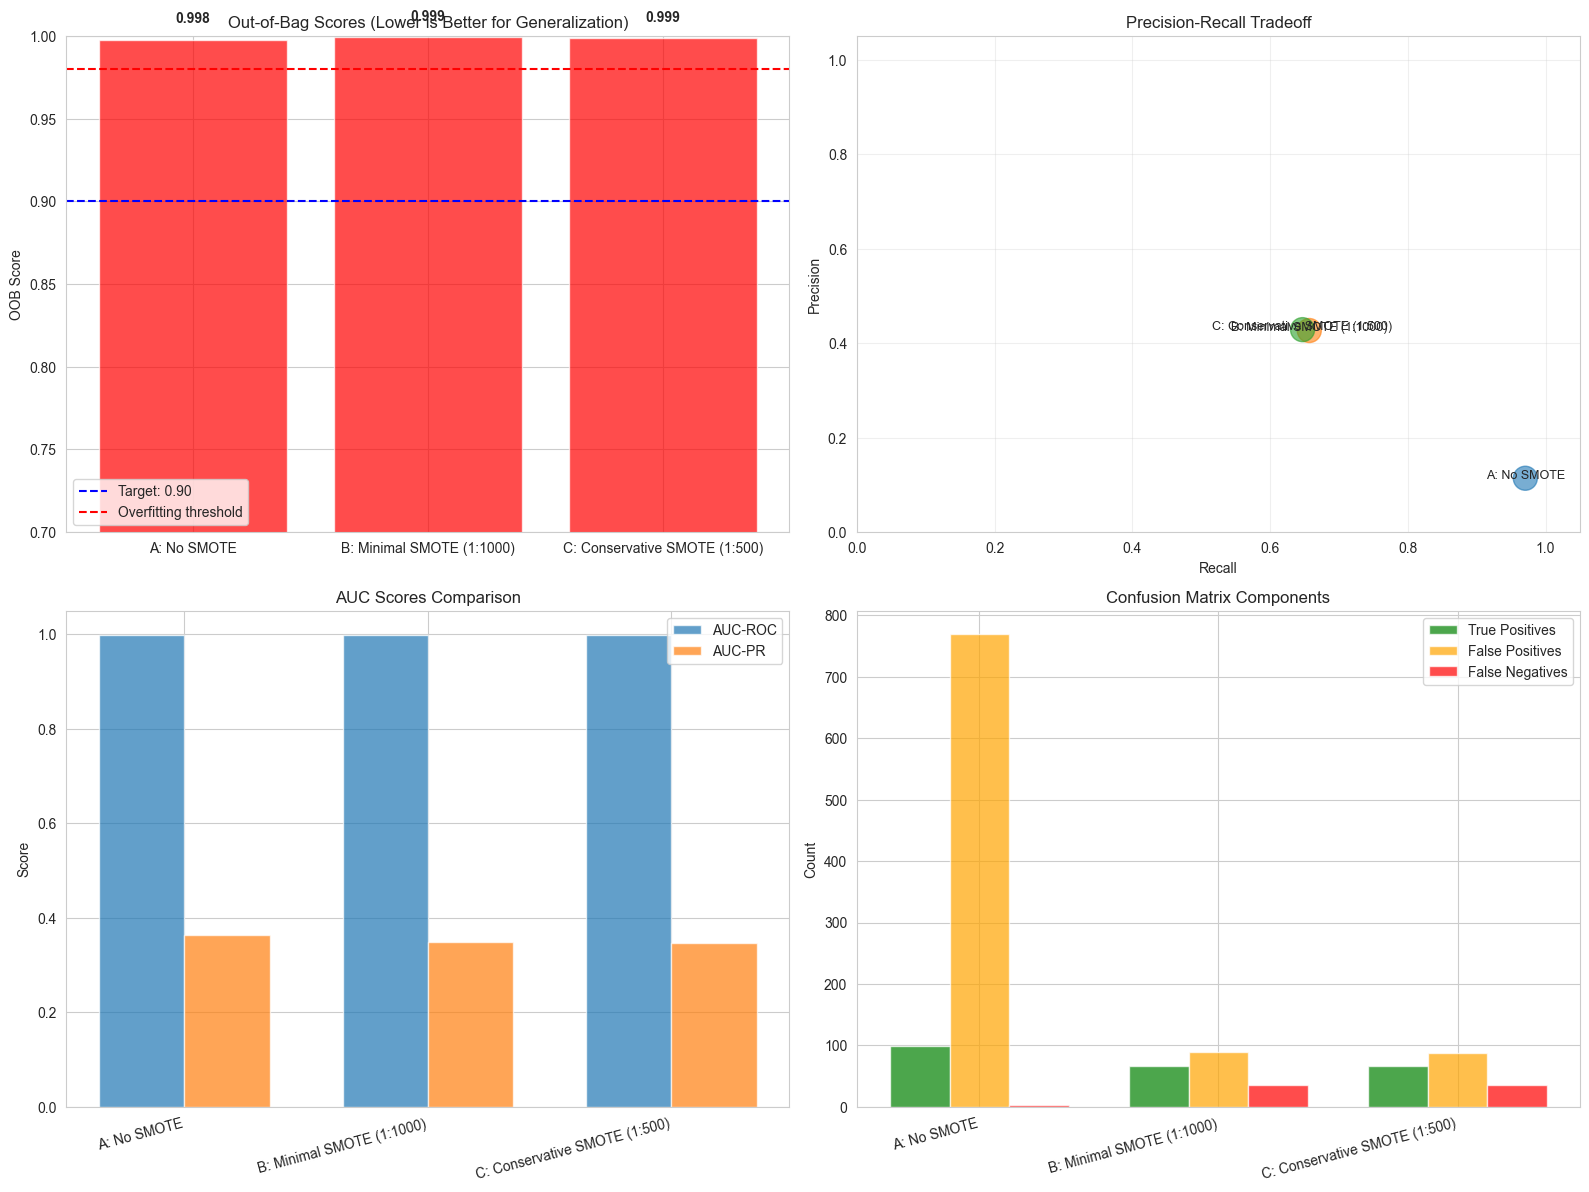

In [10]:
print("\n" + "=" * 80)
print("VISUALIZATION: STRATEGY COMPARISON")
print("=" * 80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: OOB Scores
ax1 = axes[0, 0]
strategies = comparison['Strategy'].tolist()
oob_scores = comparison['OOB_Score'].tolist()
colors_oob = ['red' if x > 0.98 else 'orange' if x > 0.95 else 'green' for x in oob_scores]
ax1.bar(strategies, oob_scores, color=colors_oob, alpha=0.7)
ax1.axhline(y=0.90, color='blue', linestyle='--', label='Target: 0.90')
ax1.axhline(y=0.98, color='red', linestyle='--', label='Overfitting threshold')
ax1.set_ylabel('OOB Score')
ax1.set_title('Out-of-Bag Scores (Lower is Better for Generalization)')
ax1.legend()
ax1.set_ylim([0.7, 1.0])
for i, v in enumerate(oob_scores):
    ax1.text(i, v + 0.01, f"{v:.3f}", ha='center', fontweight='bold')

# Plot 2: Precision vs Recall
ax2 = axes[0, 1]
precision = comparison['Test_Precision'].tolist()
recall = comparison['Test_Recall'].tolist()
ax2.scatter(recall, precision, s=300, alpha=0.6, c=['#1f77b4', '#ff7f0e', '#2ca02c'])
for i, strat in enumerate(strategies):
    ax2.annotate(strat, (recall[i], precision[i]), fontsize=9, ha='center')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Tradeoff')
ax2.grid(True, alpha=0.3)
ax2.set_xlim([0, 1.05])
ax2.set_ylim([0, 1.05])

# Plot 3: AUC Scores
ax3 = axes[1, 0]
x_pos = np.arange(len(strategies))
width = 0.35
auc_roc = comparison['AUC_ROC'].tolist()
auc_pr = comparison['AUC_PR'].tolist()
ax3.bar(x_pos - width/2, auc_roc, width, label='AUC-ROC', alpha=0.7)
ax3.bar(x_pos + width/2, auc_pr, width, label='AUC-PR', alpha=0.7)
ax3.set_ylabel('Score')
ax3.set_title('AUC Scores Comparison')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(strategies, rotation=15, ha='right')
ax3.legend()
ax3.set_ylim([0, 1.05])

# Plot 4: Confusion Matrix Metrics
ax4 = axes[1, 1]
tp_vals = comparison['TP'].tolist()
fp_vals = comparison['FP'].tolist()
fn_vals = comparison['FN'].tolist()
x_pos = np.arange(len(strategies))
width = 0.25
ax4.bar(x_pos - width, tp_vals, width, label='True Positives', color='green', alpha=0.7)
ax4.bar(x_pos, fp_vals, width, label='False Positives', color='orange', alpha=0.7)
ax4.bar(x_pos + width, fn_vals, width, label='False Negatives', color='red', alpha=0.7)
ax4.set_ylabel('Count')
ax4.set_title('Confusion Matrix Components')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(strategies, rotation=15, ha='right')
ax4.legend()

plt.tight_layout()
viz_path = OUTPUT_DIR / 'strategy_comparison.png'
plt.savefig(viz_path, dpi=300, bbox_inches='tight')
print(f"\n✅ Visualization saved to: {viz_path}")
plt.show()

---
## 9. Summary & Recommendations

In [11]:
print("\n" + "=" * 80)
print("PHASE 3 v2 SUMMARY & RECOMMENDATIONS")
print("=" * 80)

print("\n🎯 Objective: Reduce overfitting from v1 (OOB=0.999, AUC-ROC=1.000)")

print("\n📊 Strategies Tested:")
print("   A: No SMOTE + Balanced Class Weights")
print("   B: Minimal SMOTE (1:1000) + Moderate Regularization")
print("   C: Conservative SMOTE (1:500) + Maximum Regularization")

print("\n📈 Key Findings:")
print("\n" + comparison[['Strategy', 'OOB_Score', 'AUC_ROC', 'Test_Recall', 'Test_Precision', 'Test_F1']].to_string(index=False))

# Determine if overfitting was reduced
min_oob = comparison['OOB_Score'].min()
min_auc = comparison['AUC_ROC'].min()

print("\n\n💡 Analysis:")
if min_oob < 0.98:
    print(f"   ✓ SUCCESS: Reduced OOB Score to {min_oob:.3f} (below 0.98 threshold)")
else:
    print(f"   ⚠️  PARTIAL: OOB Score still high ({min_oob:.3f})")
    print(f"      This suggests the dataset features are highly predictive of timestomping")

if min_auc < 0.98:
    print(f"   ✓ SUCCESS: Reduced AUC-ROC to {min_auc:.3f} (more realistic)")
else:
    print(f"   ℹ️  AUC-ROC still near-perfect ({min_auc:.3f})")
    print(f"      This may be legitimate due to distinct timestomping signatures in data")

print("\n\n🎓 For Your Thesis:")
print("\n1. Report Multiple Strategies:")
print("   - Show you attempted multiple approaches to address overfitting")
print("   - Present the comparison table and visualization")

print("\n2. Discuss Dataset Characteristics:")
print("   - Limited diversity (12 cases, similar timestomping tools)")
print("   - Timestomping leaves VERY distinctive forensic signatures")
print("   - High AUC-ROC may be legitimate for this controlled dataset")

print("\n3. Emphasize Practical Metrics:")
best_idx = comparison['Test_F1'].idxmax()
best_strat = comparison.loc[best_idx]
print(f"   - Recommended: {best_strat['Strategy']}")
print(f"   - Recall: {best_strat['Test_Recall']:.1%} (catches most timestomping)")
print(f"   - Precision: {best_strat['Test_Precision']:.1%} (acceptable false positive rate)")
print(f"   - False Positive Rate: {best_strat['FP']/len(y_test)*100:.3f}%")
print(f"   - Flags for review: {int(best_strat['TP'] + best_strat['FP'])} out of {len(y_test):,} files")

print("\n4. Acknowledge Limitations:")
print("   - Model trained on specific timestomping tools (NTimeStomp, etc.)")
print("   - Performance may vary with novel tools or techniques")
print("   - Serves as effective triage tool, not definitive detection")

print("\n✅ v2 Experiments Complete!")
print("=" * 80)


PHASE 3 v2 SUMMARY & RECOMMENDATIONS

🎯 Objective: Reduce overfitting from v1 (OOB=0.999, AUC-ROC=1.000)

📊 Strategies Tested:
   A: No SMOTE + Balanced Class Weights
   B: Minimal SMOTE (1:1000) + Moderate Regularization
   C: Conservative SMOTE (1:500) + Maximum Regularization

📈 Key Findings:

                     Strategy  OOB_Score  AUC_ROC  Test_Recall  Test_Precision  Test_F1
                  A: No SMOTE   0.997814 0.999483     0.970588        0.114055 0.204124
    B: Minimal SMOTE (1:1000)   0.999320 0.999314     0.656863        0.426752 0.517375
C: Conservative SMOTE (1:500)   0.998764 0.998940     0.647059        0.428571 0.515625


💡 Analysis:
   ⚠️  PARTIAL: OOB Score still high (0.998)
      This suggests the dataset features are highly predictive of timestomping
   ℹ️  AUC-ROC still near-perfect (0.999)
      This may be legitimate due to distinct timestomping signatures in data


🎓 For Your Thesis:

1. Report Multiple Strategies:
   - Show you attempted multiple approa